<img src="NotebookAddons/blackboard-banner.jpg" width="100%" />
<font face="Calibri">
<br>
<font size="7"> <b> GEOS 657: Microwave Remote Sensing <b> </font>

<font size="5"> <b>Lab 3: SAR Image Processing and Geocoding <font color='rgba(200,0,0,0.2)'> -- [20 Points] </font> </b> </font>

<br>
<font size="4"> <b> Franz J Meyer; University of Alaska Fairbanks </b> <br>
<font color='rgba(200,0,0,0.2)'> <b>Due Date: </b> February 28, 2019 </font>
</font>

<img src="NotebookAddons/UAFLogo_A_647.png" width="170" align="right" /> <font size="3"> While most modern SAR data are available to you in fully focused and easy to digest data formats, some of the historic data still require processing by the end user to convert them into images that are ready for use in GIS systems. Hence, this lab will focus on how to focus raw SAR data into images and how to geocode these products and export them into GIS-ready formats. We will use the free and publicly available software tools ISCE (InSAR Scientific Computing Environment) and MapReady for processing. Both tools will be run through a **Jupyter Notebook** framework that was implemented within the Amazon Web Services (AWS) cloud. <br>

Using such a cloud-based lab has numerous advantages over physical computer pools. It comes pre-installed with all relevant processing tools and spare you the painful trouble of installing each individual package by hand. It will also ensure that all lab machines are identical, guaranteeing similar processing speed at all work stations and identical software behavior for all participants. <br><br>

This Lab is part of the UAF course <a href="https://radar.community.uaf.edu/" target="_blank">GEOS 657: Microwave Remote Sensing</a>. It will introduce the following data analysis concepts:

- SAR Image focusing using the JPL/Caltech/Stanford InSAR Scientific Computing Environment (ISCE) processing system
- Geocoding SAR imagery using Geospatial Data Abstraction Library (GDAL) tools 
- Geocoding SAR imagery using Alaska Satellite Facility's MapReady Toolbox
</font>

<font size="4"> <font color='rgba(200,0,0,0.2)'> <b>THIS NOTEBOOK INCLUDES SIX SHORT HOMEWORK ASSIGNMENTS.</b></font> Complete all six assignments to achieve full score. </font> <br>
<font size="3"> The homework assignments in this lab are to be completed outside of this notebook and are to be  <font color='rgba(200,0,0,0.2)'> submitted to me via Blackboard or email as a separate PDF document. </font> 
    
Along with the PDF of the assignments, please  <font color='rgba(200,0,0,0.2)'> also download your homework both asf PDF (*.pdf) and Notebook file (*.ipynb) and submit them as a ZIP bundle via Blackboard or email (to fjmeyer@alaska.edu) </font>. To download, please select the following options in the main menu of the notebook interface:

<ol type="1">
  <li><font color='rgba(200,0,0,0.2)'> <b> Save your notebook with all of its content</b></font> by selecting <i> File / Save and Checkpoint </i> </li>
  <li><font color='rgba(200,0,0,0.2)'> <b>To export in Notebook format</b></font>, click on <i>File / Download as / Notebook (.ipynb)</i></li>
  <li><font color='rgba(200,0,0,0.2)'> <b>To export in PDF format</b></font>, click on <i>File / Download as / PDF vs LaTeX (.pdf) </i></li>
</ol>

<b>Please rename the notebooks to include your name before submitting it via Blackboard</b>. Contact me at fjmeyer@alaska.edu should you run into any problems.
</font>

</font>

<hr>
<font face="Calibri" size="5" color="red"> <b>Important Note about JupyterHub</b> </font>
<br><br>
<font face="Calibri" size="3"> <b>Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.</b> </font>


<hr>
<font face="Calibri">

<font size="5"> <b> 0. Importing Relevant Python Packages </b> </font>

<font size="3"> The first step in any notebook is to import the required Python libraries into the Jupyter environment. In this notebooks we use the following libraries:
<ol type="1">
    <li> <b><a href="https://pandas.pydata.org/" target="_blank">Pandas</a></b> is a Python library that provides high-level data structures and a vast variety of tools for analysis. The great feature of this package is the ability to translate rather complex operations with data into one or two commands. Pandas contains many built-in methods for filtering and combining data, as well as the time-series functionality. </li>
    <li> <b><a href="https://www.gdal.org/" target="_blank">GDAL</a></b> is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing. Most modern GIS systems (such as ArcGIS or QGIS) use GDAL in the background.</li>
    <li> <b><a href="http://www.numpy.org/" target="_blank">NumPy</a></b> is one of the principal packages for scientific applications of Python. It is intended for processing large multidimensional arrays and matrices, and an extensive collection of high-level mathematical functions and implemented methods makes it possible to perform various operations with these objects. </li>
    <li> <b><a href="https://matplotlib.org/index.html" target="_blank">Matplotlib</a></b> is a low-level library for creating two-dimensional diagrams and graphs. With its help, you can build diverse charts, from histograms and scatterplots to non-Cartesian coordinates graphs. Moreover, many popular plotting libraries are designed to work in conjunction with matplotlib. </li>

</font>

In [1]:
#import pandas as pd
import gdal
from osgeo import gdal
import numpy as np
import matplotlib.pylab as plt

# ASF's Jupyter Notebook Module
from asf_notebook import path_exists
from asf_notebook import download_ASF_granule
from asf_notebook import new_directory
from asf_notebook import ASF_unzip
#from asf_notebook import get_vertex_granule_info
from asf_notebook import earthdata_login

#import requests # used for making HTTP requests
#import time
import os # for chdir, remove, getcwd
#import glob


<font face="Calibri" size="3"><b>set up matplotlib plotting</b> inside the notebook:</font>

In [2]:
%matplotlib inline 

<font size="3"> We write a couple of helper functions that check that a given file or path exists. These provide simple error handling for some of our os library function calls:</font>

<hr>
<font face="Calibri">

<img src="NotebookAddons/Huntsville-ALOS-small.jpg" width="350" align="right" /> <font size="5"> <b> 1. Focusing a SAR Raw Data Set using ISCE </b> </font>  

<font size="3"> In this first half of the lab, we will be working with an ALOS PALSAR Level 1.0 image over Huntsville, AL (we pick Huntsville here as Fairbanks is outside of the SRTM DEM mask, which would make the lab a bit more complicated). Level 1.0 describes data that has been encrypted and decoded from their original downlink format but haven’t yet been focused to final images products. Some parts of the <a href="https://www.asf.alaska.edu/" target="_blank">Alaska Satellite Facility's (ASF)</a> historic data holdings are only available in this format, requiring focusing to create a data set useful for environmental monitoring. 

Once you have completed the focusing and geocoding process for this image, you should end up with a image product similar to the one shown to your right. This map was produced by overlaying the focused ALOS PALSAR scene on top of otical data with the QGIS software. As part of the homework assignment, you will be asked to create a similar map in a GIS tool of your choice.</font>

</font>

<hr>
<font face="Calibri" size="5"> <b> 1.1 Downloading Data from the ASF SAR Archives: </b>  

<font size="3"> We will use the following short script to download individual SAR granules from the ASF SAR archives. In the example below, we download ALOS PALSAR granule *ALPSRP185270680-L1.0*. You can easily reuse this function to download other data. To do so, search the granule of interest on the <a href="https://vertex.daac.asf.alaska.edu/#" target="_blank">ASF VERTEX</a> search engine and copy the granule name into the script below. <br> 

<b>First, we define the import function:</b> </font>

<hr>
<font face="Calibri" size="3"><b>Create a working directory for this analysis and change into it:</b> </font>

In [3]:
path = "/home/jovyan/notebooks/ASF/GEOS_657_Labs/lab_3_data"
new_directory(path)
os.chdir(path)

/home/jovyan/notebooks/ASF/GEOS_657_Labs/lab_3_data already exists.


<hr>
<font face="Calibri" size="3"> To download data from ASF, you need to provide your <a href="https://www.asf.alaska.edu/get-data/get-started/free-earthdata-account/" target="_blank">NASA Earth Data</a> username to the system. Setup an EarthData account if you do not yet have one. <font color='rgba(200,0,0,0.2)'><b>Note that EarthData's ULA applies when accessing the Hyp3 API from this notebook. If you have not acknowleged the ULA in EarthData, you will need to navigate to EarthData's home page and complete that process.</b></font>
<br><br>
<b>Login to Earthdata:</b> </font>

In [4]:
api = earthdata_login()

Enter your NASA EarthData username:
aflewandowski
Enter your password:
········

 login successful!


<font face="Calibri" size="3"> <b>Download the file:</b> </font>

In [5]:
filename = download_ASF_granule("ALPSRP185270680", 'L1.0')

ALPSRP185270680-L1.0.zip is already present in current working directory.


<font face="Calibri" size="3"> <b>Unzip the file and delete it</b> to clean up after ourselves:</font><br>

In [6]:
ASF_unzip(os.getcwd(), filename)
os.remove(filename)

Extracting: ALPSRP185270680-L1.0.zip


<hr>
<font face="Calibri" size="5"> <b> 1.2 Focus a SAR Image Using <i>unpackFrame_ALOS_raw.py</i> and <i>focus.py</i></b> </font> 

<font face="Calibri" size="3"> We will be using the software package ISCE (<a href="https://winsar.unavco.org/software/isce" target="_blank">https://winsar.unavco.org/software/isce</a>) for processing our SAR data set. Processing SAR data typically involves a large number of steps that are often difficult to understand for non-SAR experts. Fortunately, these steps are largely standardized and the ISCE software team has developed useful scripts that make SAR processing much simpler for new users. We will be using two of these scripts today: </font>

<font face="Calibri" size="4"> <b><i>1.2.1 Unpack the Original SAR data:</i></b></font>
<br><br>
<font face="Calibri" size="3">To unpack and convert the input data to a format that ISCE understands, we run the ISCE script *unpackFrame_ALOS_raw.py*. Let's <b>look at the instructions for *unpackFrame_ALOS_raw.py* to familiarize ourselves with the functionality of this script.</b></font>

In [7]:
!unpackFrame_ALOS_raw.py -h

usage: unpackFrame_ALOS_raw.py [-h] -i H5DIR -o SLCDIR [-r] [-m]

Unpack CSK SLC data and store metadata in pickle file.

optional arguments:
  -h, --help            show this help message and exit
  -i H5DIR, --input H5DIR
                        Input CSK directory
  -o SLCDIR, --output SLCDIR
                        Output SLC directory
  -r, --resamp          FBD2FBS
  -m, --mult            Use multiple frames


<font face="Calibri" size="3"> Now that we are familiar with the options of *unpackFrame_ALOS_raw.py* we can <b>run the script to unpack the file we just downloaded from ASF: </b></font>

In [8]:
output_dir = "HuntsvillePALSAR"
filename = os.path.splitext(filename)[0]
!unpackFrame_ALOS_raw.py --input $filename -o $output_dir

['ALPSRP185270680-L1.0/LED-ALPSRP185270680-H1.0__A']
['ALPSRP185270680-L1.0/IMG-HH-ALPSRP185270680-H1.0__A']
HuntsvillePALSAR/HuntsvillePALSAR.raw
2019-06-21 18:17:49,287 - isce.sensor.ALOS - INFO - Extracting Level 1.0 data
.... swapping bytes
2019-06-21 18:17:49,598 - isce.sensor.ALOS - DEBUG - PRF: 2155.172
2019-06-21 18:17:49,599 - isce.sensor.ALOS - DEBUG - Bandwidth: 14000000.0
2019-06-21 18:17:49,599 - isce.sensor.ALOS - DEBUG - Pulse Length: 2.7e-05
2019-06-21 18:17:49,599 - isce.sensor.ALOS - DEBUG - Chirp Slope: -518518518518.51855
2019-06-21 18:17:49,599 - isce.sensor.ALOS - DEBUG - Range Pixel Size: 9.3685143125
2019-06-21 18:17:49,599 - isce.sensor.ALOS - DEBUG - Range Sampling Rate: 16000000.0
2019-06-21 18:17:49,599 - isce.sensor.ALOS - DEBUG - Beam Number: 7


<font face="Calibri" size="4"> <b><i>1.2.2 Let's look at the Data:</i></b></font>
<br><br>
<font face="Calibri" size="3"> 
To visualize the data, we use the visualization tool mdx.py that comes with the ISCE installation:</font>
<br><br>
<font face="Calibri" size="3"><b>Write a function to create a visualization of the raw SAR image data:</b></font>

In [9]:
def show_raw(filename, x0, y0, x_offset, y_offset):
    if path_exists(filename):
        ds = gdal.Open(filename, gdal.GA_ReadOnly)
        # extract a part of the RAW to display
        raw = ds.GetRasterBand(1).ReadAsArray(x0, y0, x_offset, y_offset).astype(np.float)
        ds = None

        fig = plt.figure(figsize=(14, 12))

        I = raw[::2]
        Q = raw[1::2]
        c = I + Q*1.j
        phase = np.arctan2(Q,I)

        # display I
        ax = fig.add_subplot(1,2,1)
        ax.imshow(np.abs(c), cmap='gray')
        ax.set_title("amp")

        # display Q
        ax = fig.add_subplot(1,2,2)
        ax.imshow(phase)
        ax.set_title("phase")

        plt.show()

        slc = None

<font face="Calibri" size="3"> <b>Visualize the unfocused SAR image:</b></font>

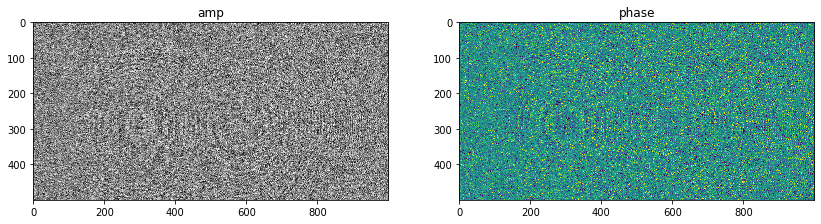

In [10]:
filename_raw = output_dir + "/" + output_dir + ".raw"
show_raw(filename_raw, 200, 200, 1000, 1000)

<font face="Calibri" size="4"> <b><i>1.2.3 Now let's Focus the SAR Image:</i></b></font>
<br>
<font face="Calibri" size="3"> 
We will be using the ready-to-use script *focus.py* to focus the ALOS PALSAR data set. This script is doing most of the work needed to focus the data set, including azimuth and range compression. You can follow the information displayed in your command window to track processing steps, which may take a couple of minutes:
</font>
<br><br>
<font face="Calibri" size="3"><b>Focus the ALOS PALSAR data set:</b></font>

In [11]:
!focus.py -i $output_dir

Heading:  -13.037686839013846
SCH velocity:  [7595.215900002173, 2.2737367544323206e-13, 9.938967080330713]
SCH acceleration:  [0.00501521753813261, -0.6156043243905677, -8.155450731570538]
Body velocity:  7595.222402978891
Height:  698717.6459655709
Radius:  6356643.510396897
Lookside:  -1
Estimated SLC Starting Range:  847166.0
 ROI - Repeat Orbit Interferometric processor
 
 actual orbital pulse spacing    3.52418351    
 
 First line to read in file 1 (start at 0)            0
 # of range input patches            4
 First sample pair to use            0
 Azimuth patch size        16384
 Number of valid points in azimuth         9216
 Deskew the image?            0
 First range bin to save in file 1            1
 Number of range bins to process         4762
 Delta range pixels for second file:            0
 Caltone location 1    0.00000000    
 Doppler centroid quad coef 1 (Hz/prf)    3.5622690514927668E-002   5.5306505535886565E-006  -8.6157870266908791E-010   0.0000000000000000   

<font face="Calibri" size="4"> <b><i>1.2.4 Visualize the Focused Image:</i></b></font>
<br><br>
<font face="Calibri" size="3"><b>Write a function to visualize complex-valued *fully focused* SAR image data:</b></font>

In [12]:
def show_slc(filename, x0, y0, x_offset, y_offset):
    if path_exists(filename):
        ds = gdal.Open(filename, gdal.GA_ReadOnly)
        # extract a part of the SLC to display
        slc = ds.GetRasterBand(1).ReadAsArray(x0, y0, x_offset, y_offset)
        ds = None

        fig = plt.figure(figsize=(14, 12))

        # display amplitude of the slc
        ax = fig.add_subplot(1,2,1)
        ax.imshow(np.abs(slc), vmin = -2, vmax=2, cmap='gray')
        ax.set_title("amplitude")

        #display phase of the slc
        ax = fig.add_subplot(1,2,2)
        ax.imshow(np.angle(slc))
        ax.set_title("phase")

        plt.show()

        slc = None

<font face="Calibri" size="3"> Before we decide how large of a chunk of the SAR image to display, <b>use *gdal.Info* to find out how many lines and pixels are contained in our data set (along with other information readable by GDAL):</b></font>

In [13]:
# 'text' can be replaced with 'json', which is much easier to parse if you need access to specific info fields
print(gdal.Info("HuntsvillePALSAR/HuntsvillePALSAR.raw.slc", options = ['text']))

Driver: ISCE/ISCE raster
Files: HuntsvillePALSAR/HuntsvillePALSAR.raw.slc
       HuntsvillePALSAR/HuntsvillePALSAR.raw.slc.xml
Size is 4762, 36864
Coordinate System is:
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]
Origin = (0.000000000000000,0.000000000000000)
Pixel Size = (1.000000000000000,1.000000000000000)
Corner Coordinates:
Upper Left  (   0.0000000,   0.0000000) (  0d 0' 0.01"E,  0d 0' 0.01"N)
Lower Left  (       0.000,   36864.000) (  0d 0' 0.01"E,Invalid angle)
Upper Right (    4762.000,       0.000) (Invalid angle,  0d 0' 0.01"N)
Lower Right (    4762.000,   36864.000) (Invalid angle,Invalid angle)
Center      (    2381.000,   18432.000) (Invalid angle,Invalid angle)
Band 1 Block=4762x1 Type=CFloat32

<font face="Calibri" size="3"><b>Pick a subset of the full SLC image and visualize its amplitude and phase using the function <i>show_slc()</i>:</b> </font>

In [ ]:
filename_slc = f"{filename_raw}.slc"
show_slc(filename_slc, 1000, 8000, 2000, 5000)

<font face="Calibri" size="4"> <b><i>1.2.5 Multilook the Scene:</i></b></font>
<br><br>
<font face="Calibri" size="3">
Often we are interested in reducing some of the noise in the data set and create pixels that are more square on the ground. To do so, we first <b>extract the image amplitude information from the complex data file:</b></font>

In [ ]:
filename_mag = f"{output_dir}/{output_dir}.mag"
!imageMath.py -e='abs(a)' --a=$filename_slc -o $filename_mag -t FLOAT

<font face="Calibri" size="3"> Now we are ready to <b>multi-look the data:</b></font>

In [ ]:
alks = 10
rlks = 2
!looks.py -i $filename_mag -a $alks -r $rlks

<font face="Calibri" size="4"> <b><i>1.2.6 Visualize the Multi-Looked Image:</i></b></font>
<br><br>
<font face="Calibri" size="3"><b>Reuse the function <i>show_slc</i> to plot the multi-looked image.</b> As we extracted only the amplitude information from the original complex SLC data, you should see that the phase component plotted below is all zero (phase was stripped from the data): </font>

In [ ]:
filename_multi_look = f"{output_dir}/{output_dir}.{alks}alks_{rlks}rlks.mag"
show_slc(filename_multi_look, 500, 800, 1000, 500)

<hr>
<font face="Calibri" size="5"> <b> 1.3 Geocode the Focused and Multi-Looked Image </b> </font> 

<font face="Calibri" size="3"> There is no good script yet to geocode SAR data using ISCE, but we will walk through the process step by step with explanations: </font>

<br>
<font face="Calibri" size="4"> <b><i>1.3.1 Grab the Relevant SRTM DEM from NASA’s DEM Repository:</i></b></font>
<br><br>
<font face="Calibri" size="3">We learned in <a href="https://radar.community.uaf.edu/module-2-imaging-radar-systems/" target="_blank">Lecture 9</a> of <a href="https://radar.community.uaf.edu/" target="_blank">GEOS 657 Microwave Remote Sensing</a> that a DEM is needed to geocode (orthorectify) our image data. This is particularly important for SAR, as the side-looking observation geometry of radar sensors causes strong topography-dependent distortions. We will use the function *dem.py* to download the necessary SRTM DEM tiles for our area of interest. *dem.py* is a nice automatic utility to download and mosaic DEM information. The “33 35 -87 -87” is the bounding box extent of our area of interest.</font>
<br><br>
<font face="Calibri" size="3"> now we are ready to <b>download and stitch the required DEM files</b>:


In [ ]:
!dem.py -b 33 35 -85 -87  -c -u  http://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.003/2000.02.11/

<br>
<font face="Calibri" size="4"> <b><i>1.3.2 Calulate Mapping Functions:</i></b> 
<br><br>
<font face="Calibri" size="3">Now we use the DEM and the image metadata information (orbit geometry; sensor look angle) to <b>calculate mapping functions between image coordinates and geographic latitude/longitude coordinates.</b> We pick the same multi-looking factor (2x10) as above.
</font>

In [ ]:
print(f"This will take a few minutes.\n")
!topo.py -a 10 -r 2 -d demLat_N33_N35_Lon_W085_W087.dem -m HuntsvillePALSAR/ -o HuntsvillePALSAR/ -n

<br>
<font face="Calibri" size="4"> <b><i>1.3.3 Create Virtual Raster Files for GDAL :</i></b> 
<br><br>
<font face="Calibri" size="3"><b>Create virtual raster files that are used by GDAL to facilitate the geocoding process:</b></font>

In [ ]:
!isce2gis.py vrt -i HuntsvillePALSAR/lat.rdr
!isce2gis.py vrt -i HuntsvillePALSAR/lon.rdr
!isce2gis.py vrt -i HuntsvillePALSAR/HuntsvillePALSAR.10alks_2rlks.mag --lat HuntsvillePALSAR/lat.rdr --lon HuntsvillePALSAR/lon.rdr

<br>
<font face="Calibri" size="4"> <b><i>1.3.4 Change into the Image Data Folder:</i></b></font>

In [ ]:
path = '/home/jovyan/notebooks/ASF/GEOS_657_Labs/lab_3_data/HuntsvillePALSAR'
if path_exists(path):
    os.chdir(path)

<br>
<font face="Calibri" size="4"> <b><i>1.3.5 Resample the Data and Convert to GeoTiff:</i></b></font>
<br><br>
<font face="Calibri" size="3"><b>Use gdalwrap to resample the file into the output coordinate system:</b></font>

In [ ]:
!gdalwarp -geoloc -tr .0001 .0001 -r bilinear  -t_srs EPSG:4326 HuntsvillePALSAR.10alks_2rlks.mag.vrt HP-intermediate.tif

<font face="Calibri" size="3"><b>Use gdal_translate to resample the file into the output coordinate system and reformat the file into GeoTIFF:</b></font>

In [ ]:
!gdal_translate -ot Byte -scale 0 2 0 255 HP-intermediate.tif HuntsvillePALSAR-geocoded.tif

<font face="Calibri" size="3"> Now the file is ready to download to your local computer and visualization in the GIS system of your choice!!</font>
<br><br>
<font face="Calibri" size="3">Before we go any further, <b>clean up the temporary files we created:</b></font>

In [ ]:
!rm *raw*
!rm *.xml*
!rm data*
!rm *mag*
!rm *rdr*
!rm HP-intermediate.tif
os.chdir('/home/jovyan/notebooks/ASF/GEOS_657_Labs/lab_3_data')
!rm demL*
!rm *.log
!rm -r ALPSRP185270680-L1.0

<br>
<hr>
<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>ASSIGNMENT #1</u>:  </font> Create a Map Overlaying your Image onto Available Background Layers </b> <font color='rgba(200,0,0,0.2)'> -- [4 Points] </font> </font>

<font face="Calibri" size="3"> 
Please download the GeoTIFF version of the geocoded image SAR image and visualize it in a GIS system of your choice. If you don't have a GIS software tool at hand, please download the open source GIS client QGIS from https://qgis.org/en/site/forusers/download.html. In QGIS, you can overlay your data set on background imagery for an assessment of the geocoding quality that was achieved. The easiest way of finding geocoded background imagery is through installing the “OpenLayers” plugin (Plugins / Manage and Install Plugins …). Once installed, you find the OpenLayers data under the **Web** tab. 

To create a map in QGIS, go to **Project / New Print Layout**. Give your composer a name (e.g., HuntsvillePALSAR) and add the image on top of the background map using Layout / Add Map. Make sure the image is nicely centered on the map. Add a coordinate system, scale, and title to the map.

Other GIS tools (e.g., ArcGIS) support similar means for map creation.Maps created using <a href="https://www.google.com/earth/versions/">Google Earth Pro</a> are also acceptable. 
</font>
</div>
<hr>

<br>
<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>ASSIGNMENT #2</u>:  </font> Evaluate the Geocoding Quality of your Map  </b> <font color='rgba(200,0,0,0.2)'> -- [3 Points] </font> </font>

<font face="Calibri" size="3"> <u>For this exercise please complete the following activities</u>:
<ol type="1">
    <li>Find a few convenient features that can be easily identified in both the SAR and background image. Measure their coordinates in both data sets and calculate mean and standard deviation of offsets that you might find (ideally they are zero). Provide a map with the used points. <font color='rgba(200,0,0,0.2)'> -- [1 Point] </font></li>
    <br>
    <li> Provide a short summary of the results of your geocoding quality analysis.<font color='rgba(200,0,0,0.2)'> -- [2 Points] </font></li> 
</ol> 
</font>
</div>
<hr>

<br>
<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>ASSIGNMENT #3</u>:  </font> Describe Image Content  </b> <font color='rgba(200,0,0,0.2)'> -- [3 Points] </font> </font>

<font face="Calibri" size="3"> <u>Pick three areas in the image that you find intriguing and compare the SAR image structure to the information in the underlying optical data.</u>:
<ol type="1">
    <li>Provide a side-by-side comparison of the SAR image and the optical data for your three areas. <font color='rgba(200,0,0,0.2)'> -- [1 Point] </font></li>
    <br>
    <li> Describe the radar cross section variations you see in the SAR image and, through comparison to the optical data, try to explain why the SAR image looks the way it does.<font color='rgba(200,0,0,0.2)'> -- [2 Points] </font></li> 
</ol> 
</font>
</div>
<hr>

<br>
<hr>
<font face="Calibri" size="5"> <b> 2. Geocoding a SAR Image using ASF MapReady </b> </font> 

<img src="NotebookAddons/Mapreadyinterface.jpg" width="450" align="right" /> <font face="Calibri" size="3"> Many of the SAR data holdings in the global archives are available as so-called ground-range projected products. While these products are typically georeferenced, they usually use an ellipsoid as a reference surface. Hence, geometric distortions such as foreshortening are not corrected in these products and geolocation errors occur at points that don’t lie at the height of the applied reference surface.

MapReady is a free software tool distributed by ASF that can be used to correct geometric distortions from SAR data and generate fully geocoded GeoTIFF products ready for use in GIS analyses. In this part of the lab, we will demonstrate the MapReady tool and use it to geocode a ERS-2 scene over Fairbanks, AK.

While MapReady also provides a Graphical User Interface (see figure to your right), the full functionality of MapReady is exposed for the generation of processing scripts, e.g., within a Jupyter Notebook framework. As previously shown, we will use the *!* character to call MapReady functions from the Jupyter Notebook code cells. 
 </font>

<hr>
<font face="Calibri" size="4"> <b> 2.1 Exploring the Functionality of Mapready </b>  

<font size="3"> We will go over some of the functionality of MapReady in the lab. For further information, please consult the <a href="http://media.asf.alaska.edu/asfmainsite/documents/mapready_manual_3.1.22.pdf" target="_blank">MapReady User Manual</a>. <br> 
</font>

<hr>
<img src="NotebookAddons/Fairbanks-ERS2-map.jpg" width="300" align="right" /> <font face="Calibri" size="4"> <b> 2.2 ERS-2 SAR Scene to be Geocoded using MapReady </b>  

<font size="3"> <a href="https://www.asf.alaska.edu/sar-data/ers-2/" target="_blank">ERS-2</a>, a C-band ($\lambda=5.66cm$) SAR operated by the European Space Agency from 1995 – 2011, has provided a wealth of Earth observation data, much of which can be accessed through the services of ASF. While the depth of the archive provides a large potential value for a range of user communities, the images of the ERS-2 archive are currently not yet available in fully geocoded formats. Hence, being able to geocode ERS-2 images will help unlock this sensor’s vast potential in environmental analysis.

The data to be geocoded is ERS-2 granule E2_80464_STD_F163, which was acquired on September 10 of 2010 over the area of Fairbanks, AK. The figure to your right provide an impression of the data set and serves to check your assignment work to be done later in this lab.

Let's download this data from ASF using the *download_file* function we created previously. Note that we reuse your NASA Earth Data username and password information.
<br> 
</font>

<hr>
<font face="Calibri" size="4"> <b> 2.3 Switch into Processing Folder and Download SAR Image File: </b>
    
<font size="3"> Before we start processing, <b>create a folder for our Fairbanks data and switch into it:</b></font> 

In [ ]:
path = '/home/jovyan/notebooks/ASF/GEOS_657_Labs/lab_3_data/FairbanksERS'
new_directory(path)
os.chdir(path)
print(f"current directory: {os.getcwd()}")

<font size="3"><b>Download the ERS-2 File over Fairbanks, Alaska:</b></font> 

In [ ]:
filename = download_ASF_granule("E2_80464_STD_F163", "L1")

<font face="Calibri" size="3"><b>Unzip the file then delete the zip:</b></font>

In [ ]:
ASF_unzip(path, filename)
os.remove(filename)
#!unzip -o $filename
#!rm $filename

<hr>
<font face="Calibri" size="4"> <b> 2.4 Retrieve DEM file for Area of Interest: </b>
    
<font size="3"> As you know, a DEM file is needed to Geocode a SAR scene correctly. The DEM represents the shape of the surface and is used to identify and correct for geometric and radiometric distortions of the side-looking SAR image data during the geocoding process. 

In this case, I prepared a DEM for you and placed it in an <a href="https://aws.amazon.com/" target="_blank">Amazon Web Service (AWS)</a> cloud storage bucket, <b>ready for your download</b>:</font> 

In [ ]:
!aws s3 cp s3://asf-jupyter-data/E2_80464_STD_F163_dem.tif E2_80464_STD_F163_dem.tif

<hr>
<font face="Calibri" size="4"> <b> 2.5 Load Image and DEM Files into MapReady: </b>

<font size="3"> This step imports the data set into MapReady, which means that we convert the original data format into something MapReady understands. </font>
</font> 

In [ ]:
!asf_import E2_80464_STD_F163/E2_80464_STD_F163 Fairbanks_ERSScene

In [ ]:
!asf_import -format geotiff E2_80464_STD_F163_dem Fairbanks_DEM

<hr>
<font face="Calibri" size="4"> <b> 2.6 Perform Terrain Correction on the SAR Data </b>

<font size="3"> This step corrects for DEM-dependent geometric and radiometric distortions in the SAR image. To perform these corrections, MapReady projects the DEM into the SAR image geometry and calculates the necessary correction parameters. 
    
We will create two different terrain correction products here: <br>
(1) A data set where **only geometric terrain correction** was applied <br>
(2) An image where **both geometric and radiometric terrain correction** was done.
</font> 

In [ ]:
# First we create a "GTC" image, a product that only has geometric correction applied:
!asf_terrcorr Fairbanks_ERSScene Fairbanks_DEM Fairbanks_ERS_GTC

In [ ]:
# Here we create a data set that has both geometric and radiometric corrections applied:
!asf_terrcorr -do-radiometric Fairbanks_ERSScene Fairbanks_DEM Fairbanks_ERS_RTC

<hr>
<font face="Calibri" size="4"> <b> 2.7 Calibration of SAR Data Products </b>

<font size="3"> This section performs calibration on the terrain-corrected data sets. SAR image data can be calibrated into several "calibration spaces" and the procedure below allows selecting the type of calibration that is to be appled. 
<ul>
<li>Typically, scientists prefer data in $\sigma$ projection, which allows relating the brightness in an image pixel to physical quantities such as surface roughness, vegtation biomass, or soil moisture. Hence, I suggest to pick $\sigma$ as your radiometric projection. This is done by adding the <i>-sigma</i>-flag to the calibration command below. Other options include the $\gamma$ and $\beta$ projections. </li>
<li>You can also choose whether to output your image in <i>amplitude</i> or <i>decibel (dB)</i> format. As radar data have enormous dynamic range, converting the pixel values to a dB scale is often recommended (at least for visualization purposes).</li>
</ul>
</font> 

In [ ]:
!asf_calibrate -db -sigma Fairbanks_ERS_GTC Fairbanks_ERS_GTC_cal

In [ ]:
!asf_calibrate -db -sigma Fairbanks_ERS_RTC Fairbanks_ERS_RTC_cal

<hr>
<font face="Calibri" size="4"> <b> 2.8 Geocode the Data Set </b>

<font size="3"> The <i>asf_geocode</i> function provides a range of options for how to geocode your data set. A number of flags can be set to customize your final geocoded product. In the following, the most important of these flags are explained. For a full list of options, please run <i>!asf_geocode -help</i> in a separate code cell:  
<ul>
<li><b><u>Projection Name (and Parameters)</u>:</b> Options include UTM (flag <i>-p utm</i>), Polar Stereographic (<i>-p ps</i>), Lambert Conformal Conic (<i>-p lamcc</i>), Lambert Azimuthal Equal Area (<i>-p lamaz</i>), and Albers Conical Equal Area (<i>-p albers</i>). In our case, we will geocode to a UTM projection. </li>
<li><b><u>Output Pixel Size</u>:</b> If this flag (<i>-pixel-size</i>) is not set, a pixel size equivalent to half the original image sampling distance is set. To change this setting, please use this flag and specify the desired pixels size in meters.</li>
</ul>
</font> 

In [ ]:
!asf_geocode -p utm Fairbanks_ERS_GTC_cal Fairbanks_ERS_GTC_cal_geo

In [ ]:
!asf_geocode -p utm Fairbanks_ERS_RTC_cal Fairbanks_ERS_RTC_cal_geo

<hr>
<font face="Calibri" size="4"> <b> 2.9 Export in a Desired Format </b>

<font size="3"> 

The <i>asf_export</i> function allows you to export your geocoded product in a range of GIS-ready formats. A number of flags can be set to customize your output format. We will output our product as a *GeoTIFF*. We furthermore will scale the image into *byte format* (aka, 256 gray values) to make sure it can easily be visualized. Note, however, that while easier to visualize, byte-formatted data destroy the phyiscal meaning of the gray values in the image. For a full list of options, please run <i>!asf_export -help</i> in a separate code cell:  
</font> 

In [ ]:
!asf_export -format geotiff -byte sigma Fairbanks_ERS_GTC_cal_geo Fairbanks_ERS_GTC_cal_geo.tif

In [ ]:
!asf_export -format geotiff -byte sigma Fairbanks_ERS_RTC_cal_geo Fairbanks_ERS_RTC_cal_geo.tif

<font face="Calibri" size="3"> Now the file is ready for download to your local computer and visualization in the GIS system of your choice!! </font>

<font face="Calibri" size="3"> *[Before we go any further, let's briefly clean up the temporary files we created ...]* </font>

In [ ]:
!rm *.meta
!rm *.img
!rm *.zip
!rm *_dem.tif
!rm -r E2_80464_STD_F163
os.chdir('/home/jovyan/notebooks/ASF/GEOS_657_Labs')

<br>
<hr>
<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>ASSIGNMENT #4</u>:  </font> Create a Map Overlaying your Image onto Available Background Layers </b> <font color='rgba(200,0,0,0.2)'> -- [4 Points] </font> </font>

<font face="Calibri" size="3"> 
Please download the GeoTIFF version of the geocoded image SAR image and visualize it in a GIS system of your choice. If you don't have a GIS software tool at hand, please download the open source GIS client QGIS from https://qgis.org/en/site/forusers/download.html. In QGIS, you can overlay your data set on background imagery for an assessment of the geocoding quality that was achieved. The easiest way of finding geocoded background imagery is through installing the “OpenLayers” plugin (Plugins / Manage and Install Plugins …). Once installed, you find the OpenLayers data under the **Web** tab. 

To create a map in QGIS, go to **Project / New Print Layout**. Give your composer a name (e.g., HuntsvillePALSAR) and add the image on top of the background map using Layout / Add Map. Make sure the image is nicely centered on the map. Add a coordinate system, scale, and title to the map.

Other GIS tools (e.g., ArcGIS) support similar means for map creation.Maps created using <a href="https://www.google.com/earth/versions/">Google Earth Pro</a> are also acceptable. 
</font>
</div>
<hr>

<br>
<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>ASSIGNMENT #5</u>:  </font> Evaluate the Geocoding Quality of your Map  </b> <font color='rgba(200,0,0,0.2)'> -- [3 Points] </font> </font>

<font face="Calibri" size="3"> <u>For this exercise please complete the following activities</u>:
<ol type="1">
    <li>Find a few convenient features that can be easily identified in both the SAR and background image. Measure their coordinates in both data sets and calculate mean and standard deviation of offsets that you might find (ideally they are zero). Provide a map with the used points. <font color='rgba(200,0,0,0.2)'> -- [1 Point] </font></li>
    <br>
    <li> Provide a short summary of the results of your geocoding quality analysis.<font color='rgba(200,0,0,0.2)'> -- [2 Points] </font></li> 
</ol> 
</font>
</div>
<hr>

<br>
<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>ASSIGNMENT #6</u>:  </font> Describe Image Content  </b> <font color='rgba(200,0,0,0.2)'> -- [3 Points] </font> </font>

<font face="Calibri" size="3"> First, you may recognize three areas in the image that are unusually bright compared to their surroundings (center coordinates: Area 1: 64°42'N, 147°55'W; Area 2: 64°43'N, 149°28'W; Area 3: 64°58'N, 148°32'W). These are burn scars related to the Willow Creek (2010), the Minto Flats (2009), and the Hardluck Creek (2009) fires.
<ol type="1">
    <li> Find the perimeters of these fires in the archives of the Alaska Interagency Coordination Center (go to <a href="https://fire.ak.blm.gov/aicc.php" target="_blank">https://fire.ak.blm.gov/aicc.php</a> and then click on Alaska Fires / Historical Fire Information) and download them as shapefiles. <font color='rgba(200,0,0,0.2)'> -- [1 Point] </font></li>
    <br>
    <li> Create a map with the fire perimeters overlaid on the SAR image and evaluate how well the SAR information traces the perimeters.<font color='rgba(200,0,0,0.2)'> -- [0.5 Points] </font></li> 
     <br>
    <li> Compare the performance of the GTC and RTC image for fire perimeter mapping. Does RTC processing improve the visibility of fire scares for any of the three fire areas?<font color='rgba(200,0,0,0.2)'> -- [1 Points] </font></li> 
    <br>
    <li> Discuss if you could use the SAR image in its current form to automatically extract the perimeters of these fires? If not, what are remaining issues? Which, GTC or RTC, image would you prefer?<font color='rgba(200,0,0,0.2)'> -- [0.5 Points] </font></li> 
</ol> 
</font>
</div>
<hr>

In [ ]:
<font face="Calibri" size="2"> <i>GEOS 657 Microwave Remote Sensing - Version 1.0 - Feb 2019 </i>
</font>